In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
# with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     lowerd = DFlow([NVPFlow(dim=k*(k-1)//2 + k, name='lowerd_flow_' + str(i)) for i in range(2)])
#     ldiag = DFlow([NVPFlow(dim=k, name='ldiag_flow_' + str(i)) for i in range(4)])
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
#                    lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')
PWalk = NormalRW(dim=None, sigma0=s0, sigma=s1)

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
init = np.array([[ 0.0309,  0.0638, -0.1418, -0.1054,  0.1332,  0.2403,  0.5305, 
                  0.2873,  0.1176, -0.0548,  0.9631,  0.0343]])[np.newaxis]
out_flow = DFlow([LinearChol(n*dim[0]*dim[1], name='approx')], init_sigma=s1)
outputs = tf.reshape(out_flow.output, [n, dim[0]*dim[1]])
outputs = tf.cumsum(outputs)[tf.newaxis]
outputs += init
# out_flow = DFlow([LinearChol(dim[0]*dim[1], name='approx')])
# outputs = tf.stack([out_flow.output]*n)

In [8]:
outputs

<tf.Tensor 'add_3:0' shape=(1, 20, 12) dtype=float64>

In [9]:
prior = PWalk.logdens(outputs)

In [10]:
prior

<tf.Tensor 'add_6:0' shape=() dtype=float64>

In [11]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [12]:
logl = create_loglik2()

In [13]:
ent = out_flow.logdens

In [14]:
ent

<tf.Tensor 'sub_1:0' shape=() dtype=float64>

In [15]:
# df = dim[0]*dim[1]*5
# pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
# cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [16]:
loss = -logl - prior + ent# - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [17]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [18]:
opt = tf.train.AdamOptimizer(0.0005).minimize(loss)

In [19]:
sess = tf.InteractiveSession()

In [20]:
tf.global_variables_initializer().run()

In [21]:
prior.eval(), ent.eval(), logl.eval()

(704.0596992899848, 766.5061978385577, -64.6989590288105)

In [22]:
loss.eval()

0.5167476638353444

In [23]:
np.set_printoptions(precision=4)

In [24]:
# PWalk.inverse_sigma.eval()[:3,:3]

In [25]:
# all_sum = tf.summary.merge_all()
# writer = tf.summary.FileWriter('/tmp/tfdbg')

In [34]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss,opt], {phase:True})
    print(l)
#     print(PWalk.inverse_sigma.eval()[:3,:3])
#     print('\n')
#     writer.add_summary(all_sum.eval())

0.3774620144955847
0.4137591542047242
0.40271913339495646
0.4116967771111921
0.425743716893147
0.39674665178245905
0.39118483004136284
0.4145879761264306
0.42275806786677017
0.3958194642090883
0.39899543951440253
0.4295750272537537
0.37216440767499204
0.42233800023763074
0.37938356390752215
0.40946106591850506
0.39835040891972634
0.39654668279911126
0.3915750232834597
0.37701643639474675
0.4486002336566661
0.3932287398595458
0.40512087501034366
0.4244979893847173
0.4057126506329036
0.39981496760786966
0.41411185685009
0.3981967393319048
0.40936510824801975
0.398446949066044
0.41778562835075234
0.41725255948998147
0.41774039941667335
0.4066452859819625
0.42906179667883654
0.4181174302931524
0.39944861487732813
0.40133389626869964
0.42944685299716007
0.41068794797128777
0.4028282888815118
0.4144853299703295
0.41241524474349234
0.4084224737565999
0.3825909899032851
0.41361655742573994
0.4028705398938906
0.40791734084581466
0.40339182631633624
0.42711651515564314
0.42958218901860284
0.3804

KeyboardInterrupt: 

In [26]:
# saver = tf.train.Saver()

In [27]:
saver = tf.train.Saver()
saver.restore(sess,'/home/nikita/tmp/rdata4')

INFO:tensorflow:Restoring parameters from /home/nikita/tmp/rdata4


In [27]:
# ss = []
# for _ in range(3000):
#     a = np.linalg.inv(PWalk.inverse_sigma.eval())
#     ss.append(np.sqrt(np.diag(a)))
# ss = np.array(ss)

In [28]:
# np.mean(ss, axis=0), np.std(ss, axis=0)

In [29]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [27]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [35]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [36]:
samples.shape

(3000, 20, 3, 4)

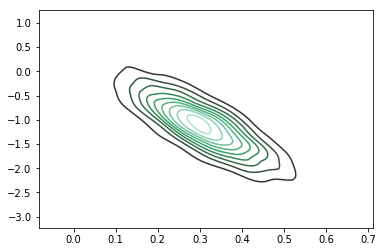

In [37]:
sns.kdeplot(samples[:,-1,2,0], samples[:,-1,0,3])
plt.show()

In [38]:
t = 10
# params[t]

In [39]:
np.mean(samples[:,t], axis=0)

array([[-0.3091,  0.0064, -0.1816, -1.1273],
       [ 0.0802,  0.2066,  0.6264,  0.4558],
       [ 0.3081, -0.0817,  0.8943,  0.6208]])

In [58]:
np.std(samples[:,t], axis=0)

array([[0.354 , 0.3569, 0.3657, 0.8392],
       [0.2299, 0.2264, 0.2241, 0.8236],
       [0.1368, 0.1353, 0.1425, 0.8592]])

In [163]:
np.mean(samples[:,t], axis=0)

array([[-0.2617, -0.0514, -0.1421, -1.1013],
       [ 0.0716,  0.1932,  0.6169,  0.2148],
       [ 0.2826, -0.0293,  0.8549,  0.9093]])

In [164]:
np.std(samples[:,t], axis=0)

array([[0.1349, 0.0932, 0.1238, 0.3107],
       [0.0814, 0.0982, 0.1407, 0.1506],
       [0.0623, 0.039 , 0.0645, 0.3178]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


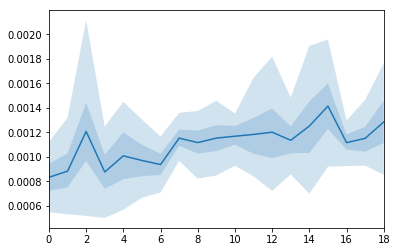

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


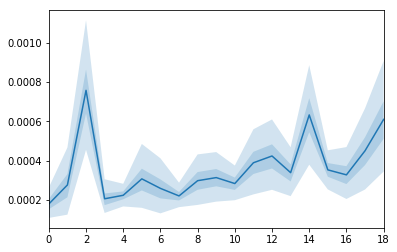

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


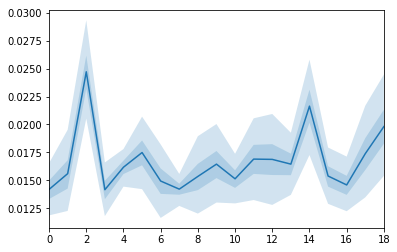

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

In [ ]:
tf.pow()